In [1]:
!pip uninstall scikit-learn -y  | egrep installed
!pip install scikit-learn ipympl | egrep installed

  Successfully uninstalled scikit-learn-1.1.2


In [2]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, FileLink, HTML
import subprocess
import sys
import pickle
import tempfile
import os
import base64
import io

Button(description='Reset Data', style=ButtonStyle())

FileUpload(value={}, description='Model Upload')

Output()

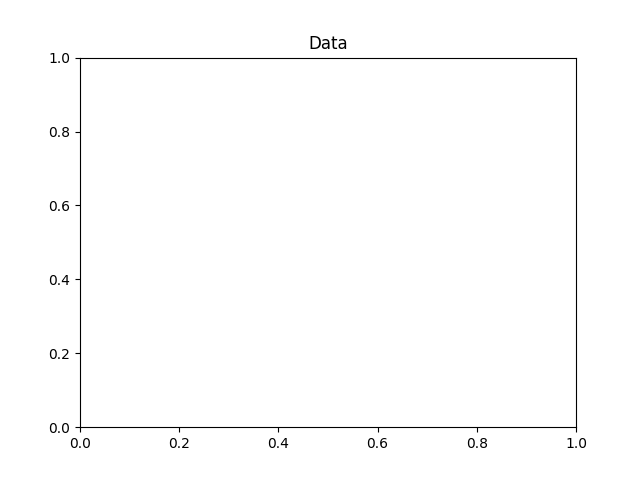

In [3]:
class DemoData:
    
    def __init__(self):
        self.data = []
        self.model = widgets.FileUpload(description="Model Upload", multiple=False)
        self.btn_gen = widgets.Button(description="Generate Data")
        self.btn_gen.on_click(self.generate_data)
        self.btn_reset = widgets.Button(description="Reset Data")
        self.btn_reset.on_click(self.reset_data)
        self.btn_download = widgets.Button(description="Download Data")
        self.btn_download.on_click(self.download_data)
        self.text_download = widgets.Label(value="")
        self.btn_inference = widgets.Button(description="Inference")
        self.btn_inference.on_click(self.inference)
        self.text_inference = widgets.Label(value="")
        self.num_data = widgets.IntText(value=1, description="# of data to generate", disabled=False)
        self.slope = 3
        self.intercept = 2
        self.stddev = 100
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        self.ax.set_title("Data")
        self.download_output = widgets.Output()
        display(widgets.HBox(children=(self.btn_gen, self.num_data)))
        display(self.btn_reset)
        display(widgets.HBox(children=(self.btn_download, self.text_download)))
        display(widgets.HBox(children=(self.btn_inference, self.text_inference)))
        display(self.model)
        display(self.download_output)
        
    def generate_data(self, btn):
        #self.output.clear_output()
        to_append = [
            {
                "x": len(self.data) + x,
                "y": (len(self.data) + x) * self.slope + self.intercept + self.stddev * np.random.randn(),
            } for x in range(self.num_data.value)
        ]
        self.data += to_append
        self.ax.clear()
        df = pd.DataFrame(self.data)
        df.plot(y="y", x="x", ax=self.ax, marker="x")
        self.fig.canvas.draw()
        
    def reset_data(self, btn):
        self.data = []
        self.ax.clear()
        self.fig.canvas.draw()
        
    def download_data(self, btn):
        if not self.data:
            self.text_download.value = "No data"
            return
        with io.BytesIO() as buf:
            df = pd.DataFrame(self.data)
            df.to_csv(buf)
            encoded = base64.b64encode(buf.getvalue())
        payload = encoded.decode()
        with self.download_output:
            self.download_output.clear_output()
            display(HTML(f"""
<html>
<body>
<a id="asdf" download="data_dumped" href="data:text/csv;base64,{payload}" download>
</a>

<script>
(function download() {{
document.getElementById('asdf').click();
}})()
</script>

</body>
</html>
"""))
        
    def inference(self, btn):
        if not self.data:
            self.text_inference.value = "No data"
            return
        if not self.model.value:
            self.text_inference.value = "No model"
            return
        df = pd.DataFrame(self.data)
        regr = pickle.loads(next(iter(self.model.value.values()))["content"])
        self.text_inference.value = f"slope: {regr.coef_[0]:.2f}, intercept: {regr.intercept_:.2f}"
        df["model"] = regr.predict(df["x"].values[:, None])
        self.ax.clear()
        df.plot(y="y", x="x", ax=self.ax)
        df.plot(y="model", x="x", ax=self.ax)
        self.fig.canvas.draw()
        
        
demo = DemoData()